In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc
#import scvi
from scvi.model import MULTIVI
from sklearn.neighbors import kneighbors_graph
#import alluvial

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [2]:
adata = anndata.read_h5ad("../Data/mixed_source_adata.h5ad.gz")

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["BLIS_NUM_THREADS"] = "4"
torch.set_num_threads(1)

In [ ]:
MULTIVI.setup_anndata(adata, batch_key='source', categorical_covariate_keys=['rep', 'tech'])
torch.set_float32_matmul_precision('high')
mvi = MULTIVI(adata, 
                          (adata.var.modality=='Gene Expression').sum(), 
                          (adata.var.modality=='Peaks').sum(),
                          fully_paired=False
            )
mvi.train(batch_size = 32,
             early_stopping = True,
             early_stopping_patience = 50,
             adversarial_mixing=True)
adata.obsm["X_multiVI"] = mvi.get_latent_representation()
adata.write("../Data/my_processed_mixed_adata_.h5ad.gz", compression='gzip')
mvi.save("../model_trained/mix_source_multivi")

In [4]:
MULTIVI.setup_anndata(adata, batch_key='source', categorical_covariate_keys=['rep', 'tech'])
mvi = MULTIVI.load("../model_trained/mix_source_multivi", adata)
adata.obsm["X_multiVI"] = mvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_multiVI")
sc.tl.umap(adata, min_dist=0.2)

INFO     File ../model_trained/mix_source_multivi/model.pt already downloaded                                      


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
# adata.write("../Data/adata.h5ad.gz", compression='gzip')

In [ ]:
# adata = anndata.read("adata.h5ad.gz")

In [ ]:
adata

# cleanup annotations

In [5]:
adata.obs["final_ct"] = adata.obs.celltype.copy()
## relabel and collapse Ding annotations to existing Satpathy annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("CD14+ monocyte", "Monocyte")
    .replace("CD16+ monocyte", "Monocyte")
    .replace("Natural killer cell", "NK Cell")
    .replace("Cytotoxic T cell", "CD8+ T Cell")
    .replace("CD4+ T cell", "CD4+ T Cell")
    .replace("Plasmacytoid dendritic cell", "pDC")
    .replace("Dendritic cell", "Dendritic Cell")
    .replace("B cell", "B Cell")
)
## relabel and collapse Satpathy annotations to match existing Ding annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("Monocytes", "Monocyte")
    .replace("NK_Cells", "NK Cell")
    .replace("Naive_CD8_T_Cells", "CD8+ T Cell")
    .replace("Memory_CD8_T_Cells", "CD8+ T Cell")
    .replace("Naive_CD4_T_Cells", "CD4+ T Cell")
    .replace("Memory_CD4_T_Cells", "CD4+ T Cell")
    .replace("CD4_HelperT", "CD4+ T Cell")
    .replace("BM_pDC", "pDC")
    .replace("Dendritic_Cells", "Dendritic Cell")
    .replace("B_Cells", "B Cell")
    .replace("Regulatory_T_Cells", "TRegs")
)
adata.obs.final_ct = adata.obs.final_ct.replace("Unassigned", "Unknown")

/tmp/ipykernel_494338/3083315937.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD14+ monocyte", "Monocyte")
/tmp/ipykernel_494338/3083315937.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD16+ monocyte", "Monocyte")
/tmp/ipykernel_494338/3083315937.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Natural kill

In [5]:
# only keep shared, cell type specific labels
adata_labelled = adata[adata.obs.final_ct.isin([
     'B Cell',
#      'Bone_Marrow',
     'CD4+ T Cell',
     'CD8+ T Cell',
     'Dendritic Cell',
#      'Megakaryocyte',
     'Monocyte',
     'NK Cell',
#      'PBMC',
#      'TRegs',
#      'Unknown',
     'pDC',
    ])].copy()

In [ ]:
#from sklearn.neighbors import kneighbors_graph
nng = kneighbors_graph(adata_labelled.obsm["X_multiVI"], n_neighbors=100).tocoo()

In [ ]:
anndf = pd.DataFrame({
    'self_label': adata_labelled.obs.final_ct[nng.row].astype(str).values,
    'neigh_label': adata_labelled.obs.final_ct[nng.col].astype(str).values,
    'self_source': adata_labelled.obs.source[nng.row].astype(str).values,
    'neigh_source': adata_labelled.obs.source[nng.col].astype(str).values,
})
anndf.head()

In [ ]:
set(anndf.self_source)

In [ ]:
anndf = anndf.loc[anndf.self_source != anndf.neigh_source]

In [ ]:
wmat = pd.crosstab(anndf.self_label, anndf.neigh_label)
wmat = (wmat.T / wmat.sum(axis=1)).T
# wmat = wmat / wmat.sum(axis=0)
# wmat

In [ ]:
order = [
    'B Cell',
    'CD4+ T Cell',
    'CD8+ T Cell',
    'NK Cell',
    'Monocyte',
    'Dendritic Cell',
    'pDC',
]
wmat = wmat.loc[order, order]

In [ ]:
sns.heatmap(wmat, cmap="YlOrBr")
plt.xlabel("")
plt.ylabel("")
plt.savefig(os.path.join(FIGPATH, "F3_annotHM.{}".format(FIGFORMAT)))

In [37]:
import sklearn.cluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# 1. 提取 MultiVI 低维嵌入
latent = adata_labelled.obsm["X_multiVI"]

from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(latent)

# 2. 设定聚类数（根据 ground truth 细胞类型数）
n_clusters = adata_labelled.obs["final_ct"].nunique()

# 3. 运行 K-means 聚类
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
adata_labelled.obs["multiVI_clusters"] = kmeans.fit_predict(latent)

# 4. 计算 ARI 和 NMI
true_labels = adata_labelled.obs["final_ct"].values  # 真实细胞类型
pred_labels = adata_labelled.obs["multiVI_clusters"].values  # K-means 聚类标签

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

asw_cell_type2=silhouette_score(latent, adata_labelled.obs.final_ct, metric='euclidean')
asw_cell_type2

Adjusted Rand Index (ARI): 0.5001
Normalized Mutual Information (NMI): 0.6141


0.15592366

In [6]:
# 重新跑 neighbors
sc.pp.neighbors(adata, use_rep="X_multiVI", n_neighbors=100)

# 跑 iLISI
from scib.metrics import lisi_graph
import pandas as pd

ilisi, clisi = lisi_graph(
    adata=adata,
    batch_key="source",
    label_key="final_ct",
    use_rep = 'X_multiVI',
    type_="knn",
    k0=100,
)

print("iLISI score:", round(ilisi, 4))
print("cLISI score:", round(clisi, 4))


iLISI score: 0.2765
cLISI score: 0.8998


In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from anndata import AnnData

def compute_graph_connectivity(adata: AnnData, embedding_key: str, label_key: str, k: int = 15) -> float:
    # Step 1: 获取嵌入和标签
    embedding = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # Step 2: 创建邻接图（基于 kNN）
    knn = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # 创建无向图（排除自身）
    G = nx.Graph()
    for i in range(len(embedding)):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    # Step 3: 对每个细胞类型计算最大连通子图比例
    unique_labels = labels.unique()
    scores = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        subgraph = G.subgraph(idx)
        if len(subgraph) == 0:
            scores.append(0.0)
            continue
        largest_cc = max(nx.connected_components(subgraph), key=len)
        scores.append(len(largest_cc) / len(idx))

    # Step 4: 平均所有细胞类型的连通性得分
    return np.mean(scores)

score = compute_graph_connectivity(
    adata=adata,
    embedding_key="X_multiVI",
    label_key="final_ct",  # 真实细胞类型
    k=50
)
print("Graph Connectivity Score:", round(score, 4))


Graph Connectivity Score: 0.9916


# UMAPs

In [9]:
adata.obsm["umap_wbc"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_multiVI"])
# adata.obsm["umap_nbc"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_multiVI_nbc"])

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


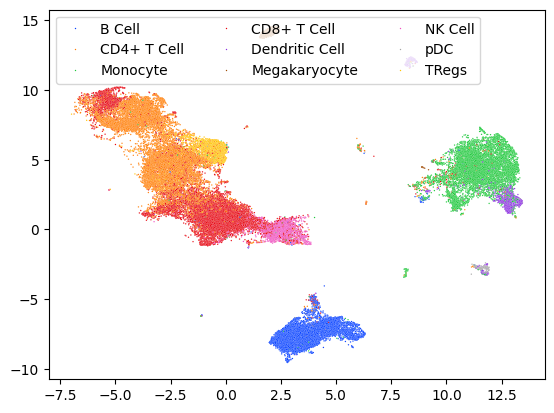

In [10]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.final_ct,
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
#     bbox_to_anchor=(1, 0.5)
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_ct.{}".format(FIGFORMAT)), bbox_inches='tight')

/tmp/ipykernel_3977323/3397652646.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Satpathy', 'scATAC (Satpathy)')
/tmp/ipykernel_3977323/3397652646.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Ding', 'scRNA (Ding)')
/tmp/ipykernel_3977323/3397652646.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x_arc', '

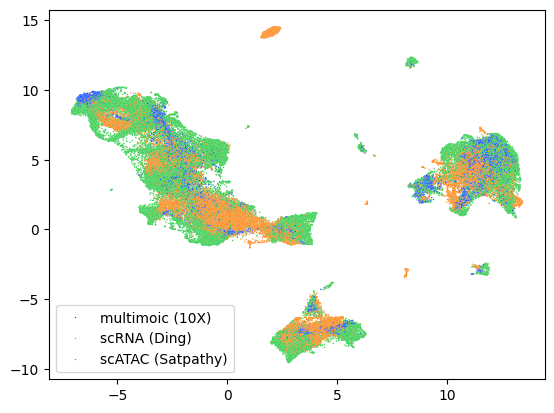

In [11]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt.obs.source = (
    adata_plt.obs.source
    .replace('Satpathy', 'scATAC (Satpathy)')
    .replace('Ding', 'scRNA (Ding)')
    .replace('10x_arc', 'multimoic (10X)')
)
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.source,
    s=1,
    palette='bright',
)
plt.legend(title='', loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_source.{}".format(FIGFORMAT)), bbox_inches='tight')

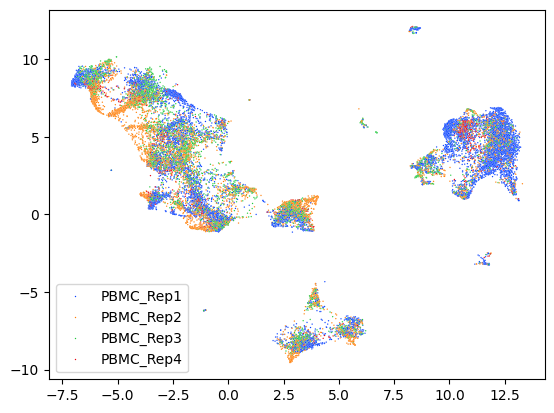

In [12]:
# plt.figure(figsize=(5,5))
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.final_ct == "PBMC"]
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.rep,
    s=1,
    palette='bright',
)
plt.legend(title=None)#, loc='center left') #, bbox_to_anchor=(1, 0.5),)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_rep.{}".format(FIGFORMAT)), bbox_inches='tight')

/tmp/ipykernel_3977323/407978484.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) A', '10x Chromium (v2)')
/tmp/ipykernel_3977323/407978484.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) B', '10x Chromium (v2)')


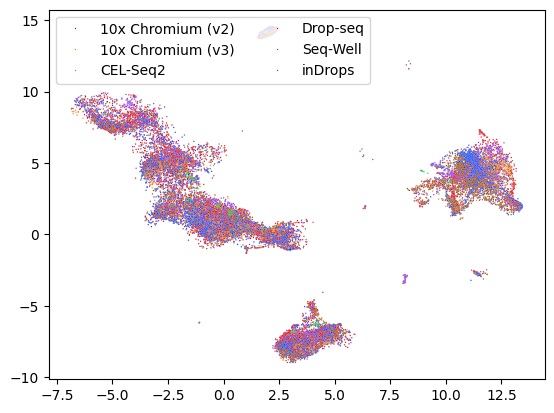

In [13]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.source == "Ding"].copy()
adata_plt.obs.tech = (adata_plt.obs.tech
                      .replace('10x Chromium (v2) A', '10x Chromium (v2)')
                      .replace('10x Chromium (v2) B', '10x Chromium (v2)')
                     )
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.tech,
    s=1,
    palette='bright',
)
plt.legend(
    loc='upper left', 
#     bbox_to_anchor=(1, 0.5), 
    ncol=2,
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_tech.{}".format(FIGFORMAT)), bbox_inches='tight')

In [21]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [ ]:
latent = adata.obsm['X_multiVI']
enrichment_rep=compute_batch_mixing(latent, adata.obs.rep, 100)
asw_rep=silhouette_score(latent, adata.obs.rep, metric='euclidean')

In [23]:
print(enrichment_rep)
print(asw_rep)

4.022068410453165
-0.15935078


In [24]:
enrichment_tech=compute_batch_mixing(latent, adata.obs.tech, 100)
asw_tech=silhouette_score(latent, adata.obs.tech, metric='euclidean')
print(enrichment_tech)
print(asw_tech)

1.8218361405909111
-0.081228875
